In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import numpy as np
import gpxSense as gpx
import matplotlib.pyplot as plt

2025-02-04 13:56:28.055741: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 13:56:28.056221: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-04 13:56:28.059122: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-04 13:56:28.066927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738673788.079757   99360 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738673788.08

In [109]:
day1_obj = gpx.LinearPredictor("29-01-2025.gpx", parameter='hr')
def from_df_to_ds(data_df, label_df, shuffle=True, batch_size=32):
	ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
	if shuffle:
		ds = ds.shuffle(1000)
	ds = ds.batch(batch_size)
	return ds
initial_lr = 0.01
epochs = 75
batch_size = 32
patience_lr_change = 50
patience_early_stop = 50

In [110]:
model1, model_history1 = day1_obj.train_model(
	initial_lr=initial_lr,
	epochs=epochs,
	batch_size=batch_size,
	patience_lr_change=patience_lr_change,
	patience_early_stop=patience_early_stop
	)

152.43863636363636
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
158.0238065766297
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.6579 - mae: 0.5078

 [0.6409085988998413, 0.5219003558158875] 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


/home/carlosg/Proyects/GPXSense/venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'ele': 'ele', 'cad': 'cad', 'dist': 'dist', 'time_acc': 'time_acc', 'pace': 'pace'}
Received: inputs={'lat': 'Tensor(shape=(None,))', 'lon': 'Tensor(shape=(None,))', 'ele': 'Tensor(shape=(None,))', 'cad': 'Tensor(shape=(None,))', 'dist': 'Tensor(shape=(None,))', 'time_acc': 'Tensor(shape=(None,))', 'pace': 'Tensor(shape=(None,))'}
  warnings.warn(msg)


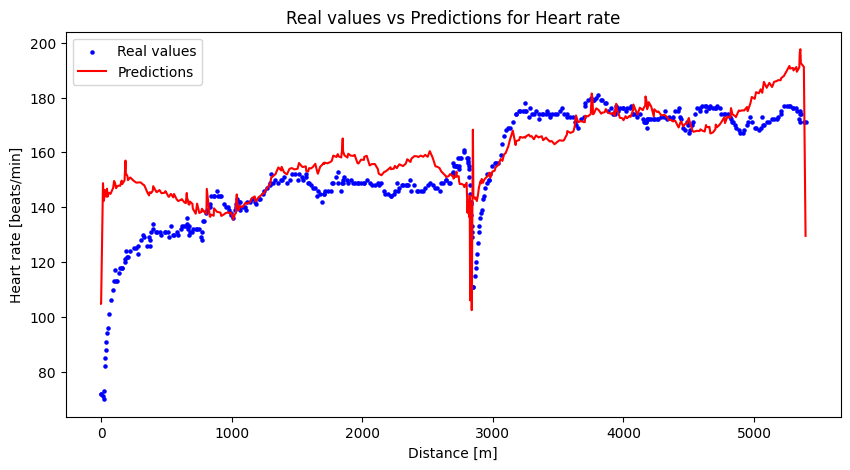

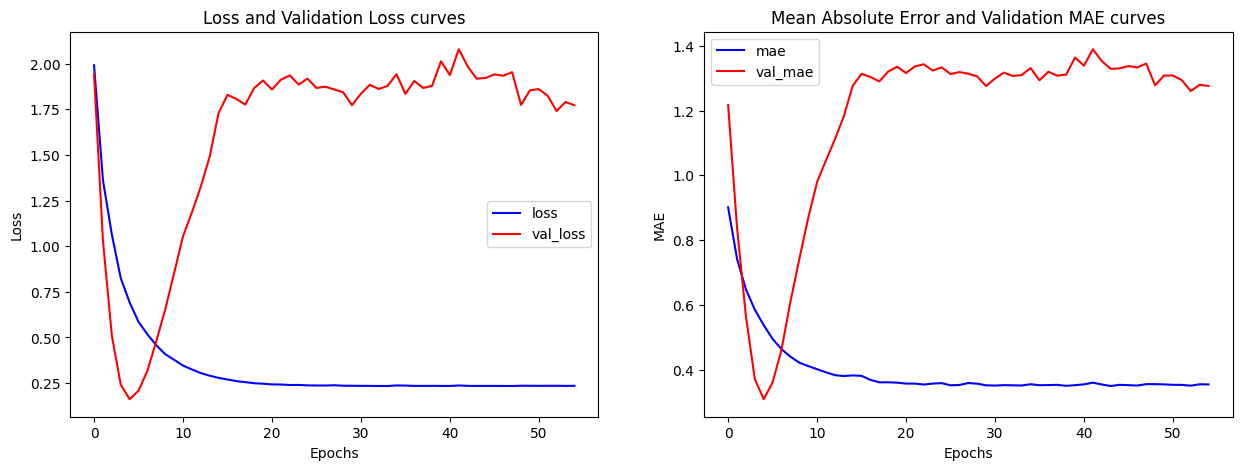

In [111]:
df = gpx.gpxAnalyseClass("31-01-2025.gpx").df
df_norm = gpx.gpxAnalyseClass("31-01-2025.gpx").df_norm
ds_norm = from_df_to_ds(df_norm.drop(['hr'], axis=1), df_norm['hr'])
print(df['hr'].mean())
print(day1_obj.predictions(model1, df_test_norm=df_norm).mean())
print("\n", model1.evaluate(ds_norm), "\n")
day1_obj.plot_predictions(model1, df_test_norm=df_norm, df_test=df)
day1_obj.plot_performance(model_history1)

Now we try only with points that represent the activity period of the session. We will discard points where the heart rate is lower or equal than the 65% of the maximum heart rate.

In [115]:
df = gpx.gpxAnalyseClass("31-01-2025.gpx").df
df_norm = gpx.gpxAnalyseClass("31-01-2025.gpx").df_norm
df_norm = df_norm.loc[df['hr'] > 0.65 * df['hr'].max()]
df = df.loc[df['hr'] > 0.65 * df['hr'].max()]
model2, model2_history = day1_obj.train_model(
	df_norm=df_norm,
	initial_lr=initial_lr,
	epochs=epochs,
	batch_size=batch_size,
	patience_lr_change=patience_lr_change,
	patience_early_stop=patience_early_stop
	)

155.38995215311004
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
163.85079283690507
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.4008 - mae: 0.4051

 [0.5046777725219727, 0.463969886302948] 



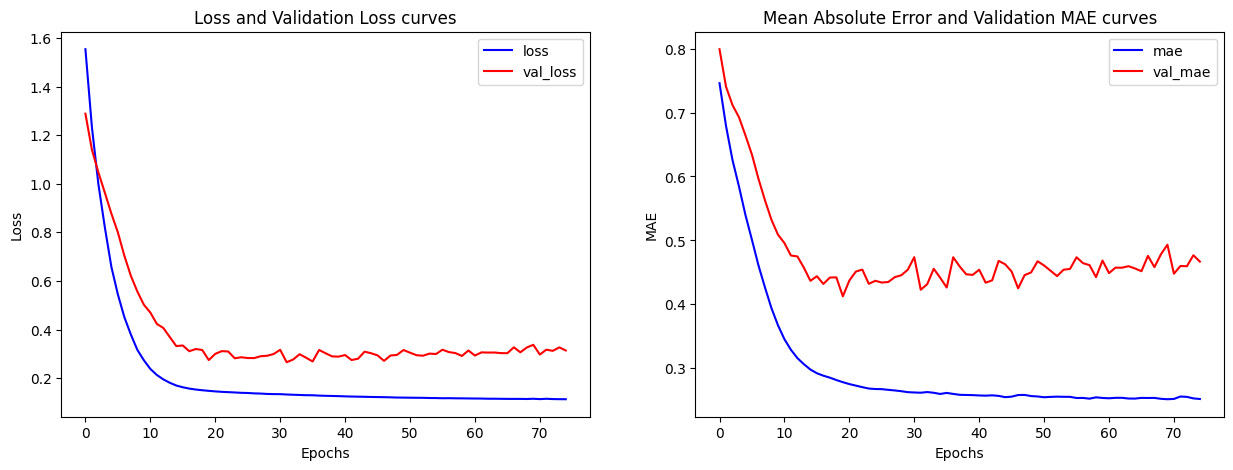

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step


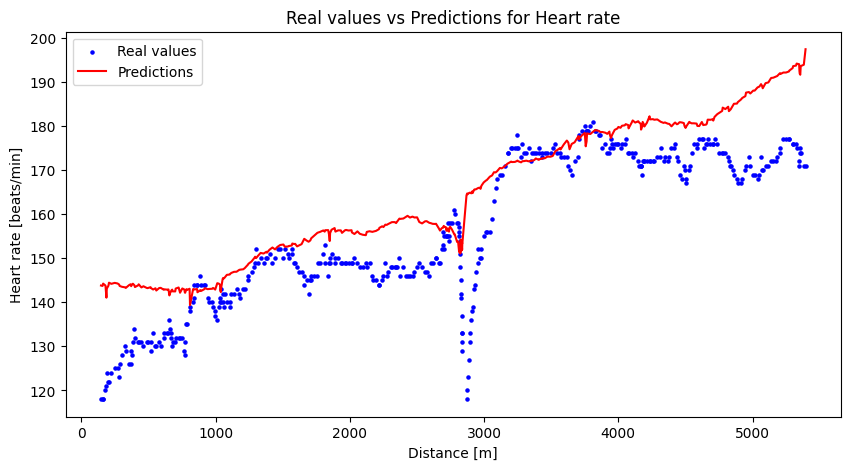

In [116]:
print(df['hr'].mean())
print(day1_obj.predictions(model2, df_test_norm=df_norm).mean())
ds_norm = from_df_to_ds(df_norm.drop(['hr'], axis=1), df_norm['hr'], shuffle=False, batch_size=batch_size)
print("\n", model1.evaluate(ds_norm), "\n")
day1_obj.plot_performance(model2_history)
day1_obj.plot_predictions(model2, df_test_norm=df_norm, df_test=df)

In [33]:

df_train = df.iloc[:int(len(df)*0.8)]
df_val = df.iloc[int(len(df)*0.8):]
y_train = df_train.pop('hr')
y_val = df_val.pop('hr')

inputs = {key: tf.keras.layers.Input(shape=(1,), name=key) for key in df_train.keys()}

x = tf.keras.layers.Concatenate()(list(inputs.values()))

output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])



def from_df_to_ds(data_df, label_df, shuffle=True, batch_size=32):
	ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
	if shuffle:
		ds = ds.shuffle(1000)
	ds = ds.batch(batch_size)
	return ds

ds_train = from_df_to_ds(df_train, y_train, batch_size=50)
ds_val = from_df_to_ds(df_val, y_val, shuffle=False)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)
]

model_history = model.fit(ds_train, validation_data=ds_val, epochs=300, verbose=0, callbacks=callbacks)